# ENERGY DEMAND FORECASTING
**Authors: Cayt Schlichting, Arsène Boundaoné, Lochlyn Laskowski, Greg Maggard**<br>
*Audience: Data Science Teams for Energy Grid Operators*

**Project Goal:** Produce a time-series model that forecasts three days of energy demand in ERCOT's coastal region. Deploying this model will allow ERCOT to anticipate demand effectively in order to schedule energy generation and inform bidding prices.



**Jump to Section:** &ensp;   [Acquisition and Prep](#acq-prep) - [Exploration](#explore) - [Modeling](#modeling) - [Conclusion](#ConclusionC88)

In [1]:
#Basics
import numpy as np
import pandas as pd
from math import sqrt
import itertools
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings('ignore')

#Viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='colorblind') #set theme for all viz
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
#pio.templates.default = "plotly_dark"
plt.rcParams["figure.figsize"] = (18,10)
plt.style.use('seaborn-colorblind')

#modeling, stats and time series
import scipy.stats as stats
alpha = .05
import datetime as dt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
from sktime.forecasting.model_selection import SlidingWindowSplitter

from pandas.tseries.holiday import USFederalHolidayCalendar
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

#Modules
import wrangle as wr

***
## Data Acquisition and Preparation  <a class="anchor" id="acq-prep">
***

**Source:** 
>    - ERCOT for energy demand data.
>    - Virtual Crossing for weather data.

**Filtering:**
> - Limited weather data to include 1/1/2010 to 6/30/22 to align with ERCOT load data.
> - Limited data to only include ERCOT's coastal region.

**Cleaning:**
> - ERCOT Data:
    - Clean up DateTime values, converting "24:00:00" values to midnight the next day.
    - Localizing DateTime values to US/Central Standard Time
    - Creating columns to highlight whether a given date is a weekday, observed holiday, and list the day of week.
> - Weather Data:
    - Shifted dates affected by Daylight Savings, so that there are no duplicates and the dates are continuous
> - Combined Data:
    - Combined the weather and ERCOT DataFrames on their newly-cleaned DateTime columns. Default output is to keep Central Standard Time, but can also be output to UTC.

##### Acquire, Prep and Split data

In [2]:
#Using a function to pull the combined weather and energy demand data:
df = wr.get_combined_df()
#add in mean_temp
df['mean_temp'] = (df.hs_temp + df.gv_temp + df.pl_temp + df.vc_temp)/4

In [3]:
#Splitting Data in to Train and Test sets by year:
train = df[:'2017']
test = df['2018':]

***
## Exploration  <a class="anchor" id="explore" />
***
*More exploration can be found in the supporting notebooks*


##### Distribution of Mean ERCOT Load Over Time

In [4]:
# wr.plot_load(train)   #Q: what is this supposed to be doing?

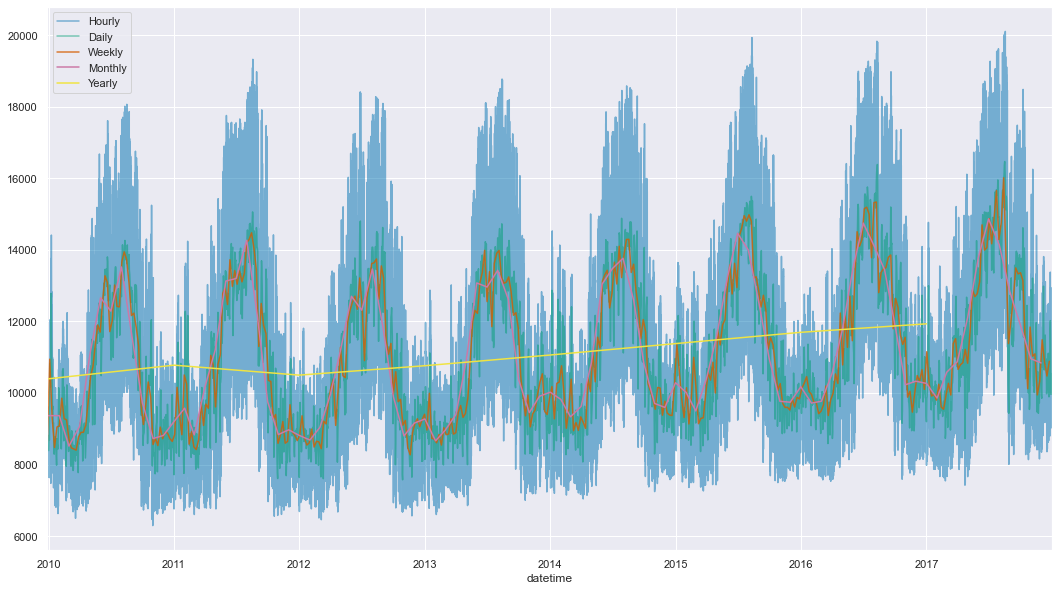

In [5]:
train.resample('H').ercot_load.mean().plot(alpha=.5, label='Hourly')
train.resample('D').ercot_load.mean().plot(alpha=.5, label='Daily')
train.resample('W').ercot_load.mean().plot(alpha=.8, label='Weekly')
train.resample('M').ercot_load.mean().plot(label='Monthly')
train.resample('Y').ercot_load.mean().plot(label='Yearly')
plt.legend();

### What do Coastal Zone Temperatures Look Like Over Time?

<div class="alert alert-success"><b>Alt Question format</b></div>

In [6]:
# wr.plot_temp(train)   #Q: what is this supposed to be doing?

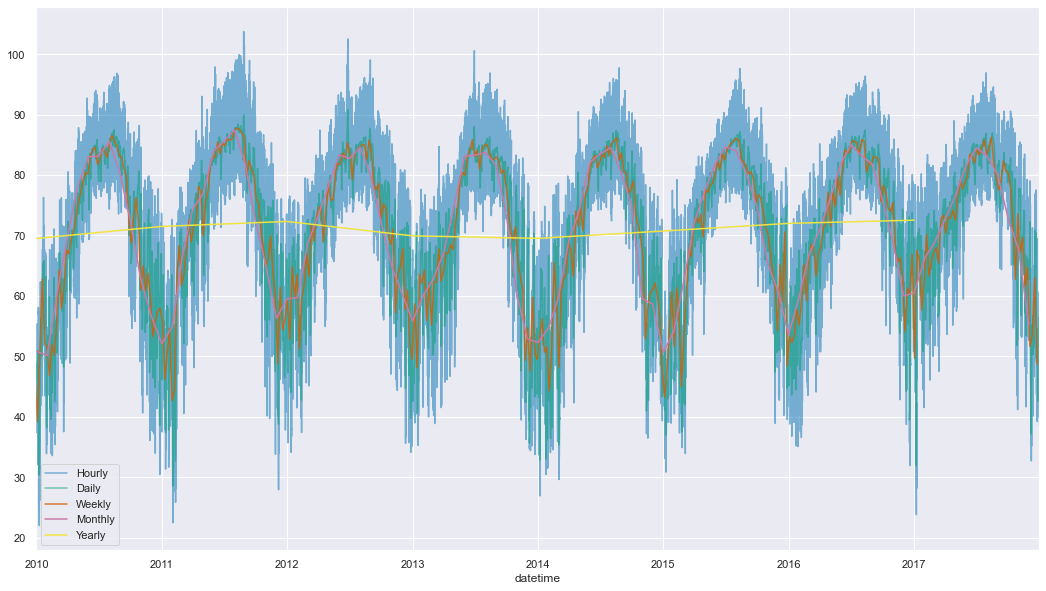

In [7]:
train.resample('H').mean_temp.mean().plot(alpha=.5, label='Hourly')
train.resample('D').mean_temp.mean().plot(alpha=.5, label='Daily')
train.resample('W').mean_temp.mean().plot(alpha=.8, label='Weekly')
train.resample('M').mean_temp.mean().plot(label='Monthly')
train.resample('Y').mean_temp.mean().plot(label='Yearly')
plt.legend();

### Energy Use by Weekday

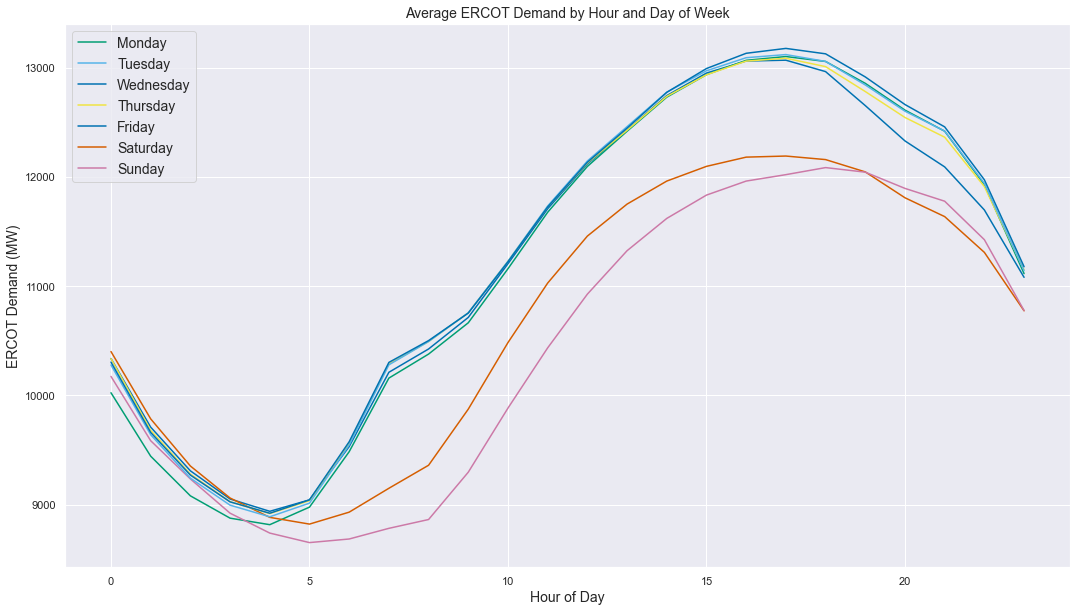

In [8]:
display(Markdown('### Energy Use by Weekday'));
ax = train.groupby([train.dow, train.index.hour]).ercot_load.mean().unstack(0).plot()
plt.title('Average ERCOT Demand by Hour and Day of Week',fontsize=14)
plt.xlabel('Hour of Day',fontsize=14)
plt.ylabel('ERCOT Demand (MW)',fontsize=14)
#Reorder legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1]] + handles[5:] + [handles[4]] + [handles[0]] + handles[2:4]
labels = [labels[1]] + labels[5:] + [labels[4]] + [labels[0]] + labels[2:4]
plt.legend(handles=handles,labels=labels,title=None,fontsize=14)
plt.show()

**Notes:**

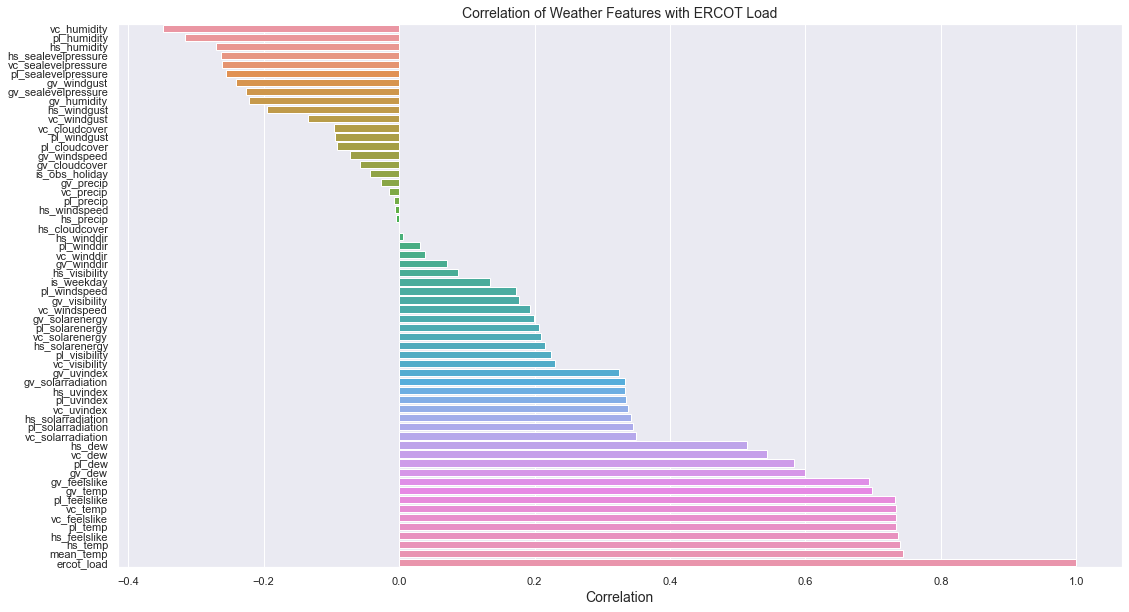

In [9]:
correlation = pd.DataFrame()
correlation['columns'] = train.corrwith(train['ercot_load'],method='spearman').index
correlation['correlation'] = train.corrwith(train['ercot_load'],method='spearman').values
sns.barplot(data=correlation.sort_values('correlation'), x='correlation', y='columns')
plt.title('Correlation of Weather Features with ERCOT Load',fontsize=14)
plt.ylabel(None)
plt.xlabel("Correlation",fontsize=14)
plt.show()

**Notes:**

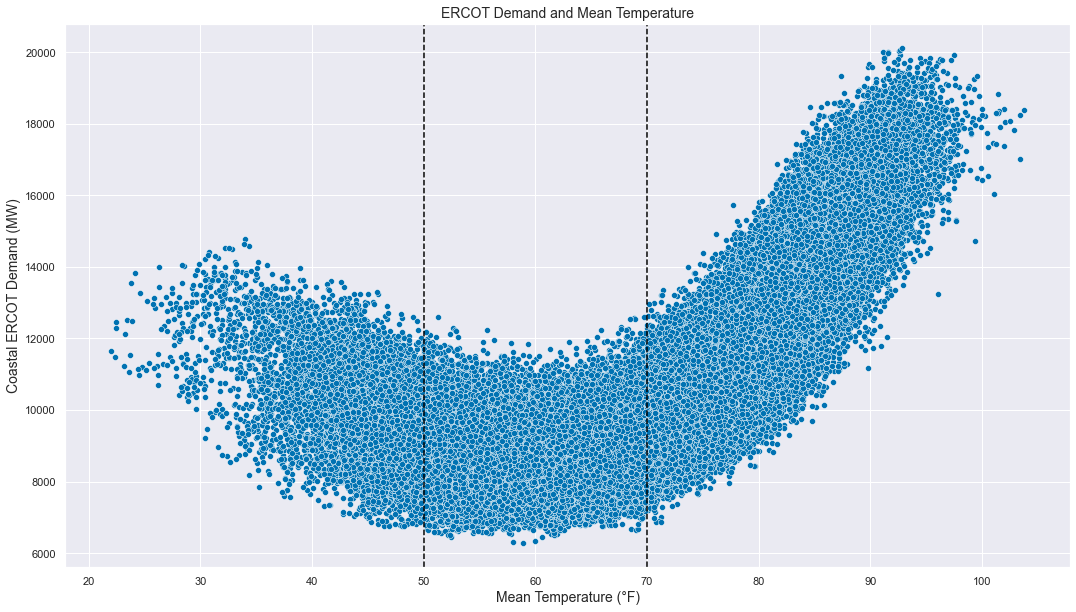

In [10]:
wr.plot_temp_ercot(train)

**Hypothesis Testing:**

<div class='alert alert-danger'><b>TO DO:</b> Clearly state a null hypothesis.  Output this a bit cleaner, or write a summary about how all rejected the null and what that means </div>

In [11]:
# Temperatures greater than 70 degrees:
less_50, mid_temp, greater_70 = wr.temp_subgroups(train)
r, p = stats.spearmanr(greater_70.ercot_load, greater_70.mean_temp)
r, p

(0.8273769795806295, 0.0)

In [12]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


In [13]:
#Temperatures between 50 and 70 degrees:
r, p = stats.spearmanr(mid_temp.ercot_load, mid_temp.mean_temp)
r, p

(0.07269098804166944, 1.0057663190117336e-27)

In [14]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


In [15]:
r, p = stats.spearmanr(less_50.ercot_load, less_50.mean_temp)
r, p

(-0.4378800064485227, 2.2237765416637823e-287)

In [16]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


<div class="alert alert-success"><b>Alt Question format</b></div>

### Exploration Summary:

> - 
> - 
> - 


***
## Modeling <a class="anchor" id="modeling" />
***
*More modeling can be found in the supporting notebooks*
    
<div class="alert alert-info"><b>MODEL EVALUATION:  These models will be evalutated using root-mean-square errorr (RMSE) and mean absolute percentage error (MAPE) on a 1 day and 3 day basis.</b>
    <ul>
        <li><b>RMSE</b> allows us to see the overall error of the model in the energy load units (MW).</li>
        <li><b>MAPE</b> complements that by telling us how accurate the model is on a percentage basis.  This is important as the energy load varies greatly throughout the year, so a 1000 MW RMSE on a hot summer day will have a much lower MAPE percentage than a 1000 MW RMSE on a comfortable Saturday in the Fall.</li>
        <li>The <b>3 day metrics</b> will tell us the overall performance of the 3 day forecast.  However, we expect the 3rd day to be less accurate than the 1st day and production models will be re-run on a daily or sub-daily basis. For that reason, we also will look at <b>1 day metrics</b> to see the model performance over the first day only.</li>
    </ul></div>
    

<div class="alert alert-info"><b>CROSS-VALIDATION:</b><br><br>Cross validation was performed on a sliding window.  Models were trained on <b>4 year initial windows</b>, with a <b>forecasting horizon of 3 days</b>.  Due to the large amount of data we had available, we minimized processing time by using a <b>36 day sliding offset</b>.  A 36 day offset ensured that our forecasting window started at different days of the week and rotated through different parts of the month. <br><br> The downside to this approach is that it is possible the model is not tested over more anomalous time periods (such as holidays or major weather events like Hurrican Harvey).  A smaller sliding offset (such as 1 or 2 days) would catch those time periods, however it would require much more processing time. </div>

##### Set up Sliding Window Splitter

In [17]:
# Setup for the implementation of the SlidingWindowSplitter
window_length = 1461*24
fh = 24*3
step_length=36*24

In [18]:
#Create Splitter object
sws = SlidingWindowSplitter(window_length=window_length, fh=fh, step_length=step_length)

### Baseline Model

<div class='alert alert-danger'>Consider modifying train to UTC, then removing time zone.  May assist runtime</div>

In [19]:
#Resample by hour
main_train = train.resample('H').ercot_load.mean().to_frame()


In [20]:
# Initialize performance dataframe
performance_df_1d = pd.DataFrame(columns=['rmse', 'mape'])
performance_df_3d = pd.DataFrame(columns=['rmse', 'mape'])

#Create cross-validation splits and run baseline on each
for i, (train_index, val_index) in enumerate (sws.split(main_train)):
    # Storing windows in our window function
    train_df = main_train.iloc[train_index]
    val_df = main_train.iloc[train_index[-1]+1:val_index[0]+1]
    
    # Creating a baseline as the last week of each train window
    baseline = train_df.iloc[-168:].ercot_load.mean()
    #Store as predicted values
    val_df['yhat'] = baseline

    #Get model performance
    rmse1 = sqrt(mean_squared_error(val_df.ercot_load[:24], val_df.yhat[:24]))
    mape1 = wr.mean_absolute_percentage_error(val_df.ercot_load[:24], val_df.yhat[:24])
    rmse3 = sqrt(mean_squared_error(val_df.ercot_load, val_df.yhat))
    mape3 = wr.mean_absolute_percentage_error(val_df.ercot_load, val_df.yhat)

    #store baseline performance in df
    perf1 = {'rmse' : rmse1, 'mape':mape1}
    perf3 = {'rmse' : rmse3, 'mape':mape3}     
    performance_df_1d = performance_df_1d.append(perf1,ignore_index=True)
    performance_df_3d = performance_df_3d.append(perf3,ignore_index=True)

In [21]:
#Get mean rmse and mape for 1 and 3 day, pretty print
wr.print_model_results('Baseline',performance_df_1d.mean().to_frame().T,performance_df_3d.mean().to_frame().T)


Baseline model performance:
1 day rmse: 1775.0 MW
1 day mape: 13.1%
3 day rmse: 1896.0 MW
3 day mape: 13.9%


### Holts-Winters Exponential Smoothing

<div class='alert alert-danger'> the seasonal periods in this was set to 4368.  That represents 6 months of 24 hours. </div>

In [22]:
# Holt-Winters fitting and prediction
hwes_perf_df_1d = pd.DataFrame(columns=['rmse', 'mape'])
hwes_perf_df_3d = pd.DataFrame(columns=['rmse', 'mape'])

for i, (train_index, val_index) in (enumerate (sws.split(main_train))):
    # Storing windows in DataFrames for train and validate
    hwes_train_df = main_train.iloc[train_index]
    hwes_val_df = main_train.iloc[train_index[-1]+1:val_index[0]+1]
    
    # Creating a model as the last week of each train window
    model = ExponentialSmoothing(endog = hwes_train_df.ercot_load, 
                             trend ='add', 
                             seasonal = 'add', 
                             seasonal_periods = 24).fit() #4368 - lower may allow faster run time
    #get model predictions
    pred = model.predict(start=hwes_val_df.index[0], end=hwes_val_df.index[-1])
    predictions = pred.to_frame(name='ercot_load')

    #Get model performance
    rmse1 = sqrt(mean_squared_error(hwes_val_df.ercot_load[:24], predictions.ercot_load[:24]))
    mape1 = wr.mean_absolute_percentage_error(hwes_val_df.ercot_load[:24], predictions.ercot_load[:24])
    rmse3 = sqrt(mean_squared_error(hwes_val_df.ercot_load, predictions.ercot_load))
    mape3 = wr.mean_absolute_percentage_error(hwes_val_df.ercot_load, predictions.ercot_load)

    #store baseline performance in df
    perf1 = {'rmse' : rmse1, 'mape':mape1}
    perf3 = {'rmse' : rmse3, 'mape':mape3}     
    hwes_perf_df_1d = hwes_perf_df_1d.append(perf1,ignore_index=True)
    hwes_perf_df_3d = hwes_perf_df_3d.append(perf3,ignore_index=True)



/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model

In [23]:
#Get mean rmse and mape for 1 and 3 day, pretty print
wr.print_model_results('Holts-Winters Exponential Smoothing',performance_df_1d.mean().to_frame().T,performance_df_3d.mean().to_frame().T)

Holts-Winters Exponential Smoothing model performance:
1 day rmse: 1775.0 MW
1 day mape: 13.1%
3 day rmse: 1896.0 MW
3 day mape: 13.9%


### Prophet Models

**Note:** You will notice that we re-acquire the dataframes in this section.  Prophet requires time zone naive inputs, however we wanted our explore section above to display CST time zones for readability.

In [24]:
#Acquire data
dfr = wr.get_prophet_df_w_meantemp()
#Filter train based on CST time (EOY 2017, time zone naive UTC time is in this df)
trainr = dfr[dfr.ds < '2018-01-01 06:00:00']

#Create df w/o regression column
train = trainr[['ds','y']].copy()

In [25]:
#Set metrics to evaluate
metrics = ['rmse','mape']

##### Basic Prophet model
- Uses default Prophet settings:
  - Auto for all seasonality
  - No holidays
  - No regression

In [26]:
#Create and Fit Basic Prophet model
model = Prophet().fit(train)

#Create cross-validation matrix
df_cv = cross_validation(model,initial='1461 days', period='36 days', horizon = '3 days')

#Get 1 and 3 day model performance
df_p_1d = performance_metrics(df_cv,rolling_window=.33,metrics=metrics)
df_p_3d = performance_metrics(df_cv,rolling_window=1,metrics=metrics)

19:57:12 - cmdstanpy - INFO - Chain [1] start processing
19:57:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/41 [00:00<?, ?it/s]

19:57:41 - cmdstanpy - INFO - Chain [1] start processing
19:57:52 - cmdstanpy - INFO - Chain [1] done processing
19:57:53 - cmdstanpy - INFO - Chain [1] start processing
19:58:01 - cmdstanpy - INFO - Chain [1] done processing
19:58:03 - cmdstanpy - INFO - Chain [1] start processing
19:58:14 - cmdstanpy - INFO - Chain [1] done processing
19:58:16 - cmdstanpy - INFO - Chain [1] start processing
19:58:29 - cmdstanpy - INFO - Chain [1] done processing
19:58:30 - cmdstanpy - INFO - Chain [1] start processing
19:58:43 - cmdstanpy - INFO - Chain [1] done processing
19:58:44 - cmdstanpy - INFO - Chain [1] start processing
19:58:56 - cmdstanpy - INFO - Chain [1] done processing
19:58:57 - cmdstanpy - INFO - Chain [1] start processing
19:59:07 - cmdstanpy - INFO - Chain [1] done processing
19:59:08 - cmdstanpy - INFO - Chain [1] start processing
19:59:22 - cmdstanpy - INFO - Chain [1] done processing
19:59:23 - cmdstanpy - INFO - Chain [1] start processing
19:59:36 - cmdstanpy - INFO - Chain [1]

In [27]:
#print model results
wr.print_model_results('Basic Prophet',df_p_1d,df_p_3d)

Basic Prophet model performance:
1 day rmse: 1220.0 MW
1 day mape: 8.1%
3 day rmse: 1302.0 MW
3 day mape: 8.5%


##### Prophet model v2 - Hyperparameter first pass 
- Remove auto-seasonality
- manually add seasons:
  - daily fourier order of 6, with a scale of 30
  - weekly fourier order of 6, with a scale of 30
  - yearly fourier order of 6, with a scale of 10
- Added US Federal observed holidays
- Added mean temperature regressor

In [28]:
#PREP Holidays
#create calendar object
cal = USFederalHolidayCalendar()
#get holidays as list of dates
train_holidays = cal.holidays(start=trainr.ds.min(),end=trainr.ds.max())

# Transition to dataframe with holiday, ds columns
holiday_df = pd.DataFrame(trainr.ds)
#For each datetime, get if it lands on a holiday
holiday_df['holiday'] = holiday_df.ds.dt.date.astype(str).isin(train_holidays.astype(str)).astype(int)

In [29]:
#Filter down to just the holidays
only_holidays = holiday_df[holiday_df.holiday==1]
#Convert that column to string
only_holidays.holiday = only_holidays.holiday.astype(str)

In [30]:
#Create the model
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            holidays=only_holidays)
#Add seasonalities
m = m.add_seasonality(name='daily', 
                      period=1, 
                      fourier_order=6,
                      prior_scale=30
                     )
m = m.add_seasonality(name='weekly', 
                      period=7, 
                      fourier_order=6,
                      prior_scale=30
                     )
m = m.add_seasonality(name='yearly', 
                      period=365.25, 
                      fourier_order=6,
                      prior_scale=10
                     )
#Add Regressors
m = m.add_regressor('mean_temp')

### Modeling Summary:

> - 
> - 
> - 


***
## Conclusion <a class="anchor" id="ConclusionC88" />
***

**Goal Recap:** 

**Key Findings:**
> - 
> -
> - 
> -

**Recommendations:**
> - 
> - 


**Next Steps:**
> - 
> -


***
## Appendix:
***

*place for more complex graphs and implications relevant for next steps.  Or just add extra details that I don't want to take away from the rest of the report*